## Определение перспективного тарифа телекомпании

### Описание проекта

У компании есть два тарифных планах "Смарт" и "Ультра", необходимо определить какой тариф приносит больше денег по выборке 500 клиентов.
  
| |«Смарт»|«Ультра»|
|--|--|--|
|Ежемесячная оплата|550|1950|
|Включено:|||
|Минут разговора|500|3000|
|Сообщений|50|1000|
|Гб трафика|15|30|
|Стоимость свыше:|||
|Минут разговора|3|1|
|Сообщений|3|1|
|Гб трафика|200|150|

Проверить 2 гипотезы:  
- Средняя выручка тарифов «Ультра» и «Смарт» различаются 
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Знакомство с данными и придение к нужным типам данных

In [141]:
import pandas as pd
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
matplotlib.style.use('seaborn-pastel')

In [6]:
pd.options.display.float_format ='{:,.3f}'.format

In [7]:
try:
    df_users = pd.read_csv('users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('tariffs.csv')
except:
    df_users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [9]:
df_users[df_users.duplicated(subset=['last_name', 'first_name'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [10]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

`df_users` - дубликатов нет, пропущенные значения только в дате прекращения пользования тарифом(но согласно документации, данный тариф действующий). Все данные в правильных форматах.

In [11]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [12]:
df_calls[df_calls.duplicated(subset='id')]

,id,call_date,duration,user_id


`df_calls` - необходимо поправить duration(длительность звонка в минутах), т.к. в описании тарифа должно быть округление до целого. соответственно привести к int. еще конечно в идеале id хранить в int, но не уверен что стоит сейчас это делать.

In [13]:
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [14]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [15]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [16]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


`df_messages` - Проблем не обнаружено, вроде все ок и все в правильном типе. Разве что можно поменять id на int

In [17]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [18]:
df_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,"1,052.810",2018-09-07,1000
2,2,1000_2,"1,197.260",2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


`df_internet` : Затисалась странная колонка, которую стоит удалить. мб надо будет перевести в гб, после того сделается сводная таблица

In [19]:
df_internet.drop(columns='Unnamed: 0', inplace=True)

In [20]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [21]:
df_tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


`df_tariffs` - все ок.

**Общий вывод**:  
В целом данные хорошие, пропусков нет, дубликатов нет, возможно появяться скрытые проблемы после того как начну группировать/ проводить аналитику

### Добавление колонок и создание сводных таблиц

In [22]:
# Проверка что все действия за 2018год и не вписалось ничего лишнего
df_calls['call_date'].describe(datetime_is_numeric=True)
df_internet['session_date'].describe(datetime_is_numeric=True)
df_messages['message_date'].describe(datetime_is_numeric=True)

count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

In [23]:
df_calls['call_month'] = df_calls['call_date'].dt.month
df_internet['internet_month'] = df_internet['session_date'].dt.month
df_messages['message_month'] = df_messages['message_date'].dt.month

In [24]:
df_internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id', 'internet_month'], dtype='object')

In [25]:
df_pivot_calls = df_calls.pivot_table(
    values=['duration'], index=['user_id', 'call_month'], aggfunc=['sum']).reset_index()
df_pivot_calls.columns = ['user_id', 'month', 'sum_duration']

In [26]:
df_pivot_internet = df_internet.pivot_table(
    values=['mb_used'], index=['user_id','internet_month'], aggfunc=['sum']).reset_index()
df_pivot_internet.columns = ['user_id','month', 'mb_used']

Сразу переведем мегабайты в гигабайты, которые требуются для расчета стоитмости

In [27]:
df_pivot_internet['gb_used'] = np.ceil(df_pivot_internet['mb_used'] / 1024).astype(int)
df_pivot_internet.drop(columns=['mb_used'], inplace=True)

In [28]:
df_messages.columns

Index(['id', 'message_date', 'user_id', 'message_month'], dtype='object')

In [29]:
df_pivot_messages = df_messages.pivot_table(
    values=['id'], index=['user_id', 'message_month'], aggfunc=['count']
).reset_index()
df_pivot_messages.columns = ['user_id', 'month', 'count_message']

In [30]:
df_users['reg_date'].describe(datetime_is_numeric=True)

count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

Создание основной сводной таблицы

In [31]:
df_users['reg_month'] = df_users['reg_date'].dt.month
df_users['unreg_month'] = df_users['churn_date'].dt.month

In [32]:
df_users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'reg_month', 'unreg_month'],
      dtype='object')

In [33]:
df_main = pd.DataFrame(columns=['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 
                                'reg_date', 'tariff', 'reg_month', 'unreg_month', 'month'])


In [34]:
def app_users(row):
    global df_main
    if row['unreg_month'] is None:
        max_month = row['unreg_month']
    else:
        max_month = 13
    for i in range(row['reg_month'] + 1, int(max_month)):
        row['month'] = i
        df_main = df_main.append(row)
    return row

In [35]:
df_users.apply(app_users, axis=1).head(1)

,age,churn_date,city,first_name,last_name,month,reg_date,reg_month,tariff,unreg_month,user_id
0,52,NaT,Краснодар,Рафаил,Верещагин,12.000,2018-05-25,5,ultra,NaN,1000


In [36]:
df_main = df_main.merge(df_pivot_internet, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_calls, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_messages, how='left', on=['user_id', 'month'])

Получили сводную таблицу, только с полными месяцами использования. Есть некоторые месяцы с пропусками, скорее всего связано с тем, что человек не пользовался услугами связи в эти месяцы. Заполним нулями, чтоб пропуски отображались в статистике

In [37]:
columns_for_change_none = ['sum_duration', 'gb_used', 'count_message']
for column in columns_for_change_none:
    df_main[column].fillna(value=0, inplace=True)

In [38]:
df_main.rename(columns={'tariff' : 'tariff_name'}, inplace=True)
df_main = df_main.merge(df_tariffs, how='outer', on='tariff_name')

<AxesSubplot:>

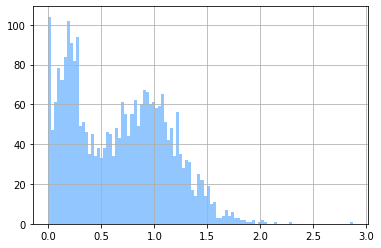

In [39]:
# Какой % использован из выделенного тарифа
df_main['per_minutes'] = df_main['sum_duration'] / df_main['minutes_included']
df_main['per_minutes'].hist(bins=100)

Наткнулся на проблему: что есть включенные мегабайты, а цена за гигабайты... поэтому переводим в гигабайты как делали ранее

In [40]:
df_main['gb_included'] = (df_main['mb_per_month_included']/1024).astype(int)
df_main.drop(columns='mb_per_month_included', inplace=True)

In [41]:
def check_money(include, spent, price):
    def check_money_inside(row):
        nonlocal include, spent, price
        if row[spent] <= row[include]:
            return 0 
        elif row[spent] > row[include]:
            return (row[spent] - row[include])*row[price] 
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [42]:
def check_money(include, spent, price):
    '''Функция для подсчета затраченного сверх тарифа(минут/гб/смс)'''
    def check_money_inside(row):
        nonlocal include, spent, price
        return 0 if row[spent] <= row[include] else (row[spent] - row[include])*row[price]
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [43]:
df_main['total_rub_duration'] = df_main.apply(minutes, axis=1)
df_main['total_rub_internet'] = df_main.apply(internet, axis=1)
df_main['total_rub_messages'] = df_main.apply(messages, axis=1)
df_main['total_rub_service'] = df_main['total_rub_duration'] + \
    df_main['total_rub_internet'] + df_main['total_rub_messages'] 
df_main['total_rub'] = df_main['total_rub_service'] + \
    df_main['rub_monthly_fee']

In [44]:
df_main['service_bool'] = df_main.apply(
    lambda row: 0 if row['total_rub'] == row['rub_monthly_fee'] else 1, axis=1
)

In [45]:
df_ultra = df_main.query('tariff_name == "ultra"')
df_smart = df_main.query('tariff_name == "smart"')

Данные подготовил, далее идет аналитика, гипотезы и т.п., предварительно удаляю все левые переменные, чтоб глаза не мазолили

In [46]:
del df_calls, df_internet, df_users, df_tariffs, df_messages
del df_pivot_calls, df_pivot_internet, df_pivot_messages, 
del column, columns_for_change_none

### Ответы на вопросы и анализ

#### Функция отрисовки

In [132]:
def show_hist(name_column, text, hist_range, ylim=True):
    '''Функция для отрисовки графика и вывода основных значений

    Args:
        name_column (str): колонка df по которой строить
        text (str): Название таблицы
        hist_range (tuple): Диапазон для которой строить гистограмму плотностей
        ylim (list): Высота по y для абсолютных значений
    '''
    ultra_list = df_ultra[name_column]
    ultra_std = np.std(ultra_list)  # Стандартное отклонение
    ultra_var = np.var(ultra_list)  # Дисперсия
    ultra_mean = ultra_list.mean()  # Мат. ожидание

    smart_list = df_smart[name_column]
    smart_std = np.std(smart_list)
    smart_var = np.var(smart_list)
    smart_mean = smart_list.mean()

    fig = plt.figure(figsize=(14,5))
    x_axis = np.arange(*hist_range)
    ax1 = fig.add_subplot(121)
    ax1.plot(x_axis, st.norm.pdf(x_axis, smart_mean, smart_std), color='red', label='Smart')
    ax1.plot(x_axis, st.norm.pdf(x_axis, ultra_mean, ultra_std), color='blue', label='Ultra')
    plt.ylabel('Плотность распределения')
    plt.xlabel('Значения')
    plt.title(text)
    plt.legend()
    ax2 = fig.add_subplot(122)
    df_smart_group = df_smart.groupby(name_column)['user_id'].count()
    df_ultra_group = df_ultra.groupby(name_column)['user_id'].count()
    ax2.plot(df_smart_group, color='red', label='Smart')
    ax2.plot(df_ultra_group, color='blue', label='Ultra')
    plt.ylim(ylim)
    plt.xlabel('Значения')
    plt.title('График абсолютных значений')
    plt.legend()
    plt.show
    print(f'STD (Ultra) | STD (Smart) : {ultra_std:.2f} | {smart_std:.2f}')
    print(f'VAR (Ultra) | VAR (Smart) : {ultra_var:.2f} | {smart_var:.2f}')
    print(f'MEAN (Ultra)| MEAN (Smart): {ultra_mean:.2f} | {smart_mean:.2f}')


#### Использование интернета

STD (Ultra) | STD (Smart) : 9.82 | 5.19
VAR (Ultra) | VAR (Smart) : 96.40 | 26.92
MEAN (Ultra)| MEAN (Smart): 20.44 | 17.34


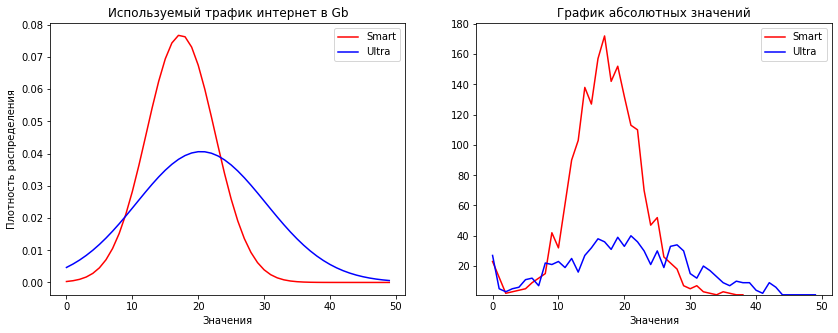

In [133]:
show_hist('gb_used', 'Используемый трафик интернет в Gb', (0,50,1))

In [119]:
per_smart = len(df_smart.query('gb_used >= gb_included')) / len(df_smart)
per_ultra = len(df_ultra.query('gb_used >= gb_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", использующие больше включенного трафика: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", использующие больше включенного трафика: {per_ultra:.2%}')

Пользователи тарифа "Смарт", использующие больше включенного трафика: 72.03%
Пользователи тарифа "Ультра", использующие больше включенного трафика: 17.04%


По гистограмме распределения видно
- Люди использующие тариф смарт стараются попадать в тариф и следят за трафиком, но далеко не всегда выходит
- Пользователи тарифа "Ультра" какие то пофигисты и всего 1/5 использует сверх трафика
- Разброс используемоего трафика в тарифе ультра гораздо больше, соответственно и дисперсия больше
- Интересно, что среднее значение у тарифов отличается всего на 3гб по выборке... но это толком ни о чем не говорит

#### Использование мобильной связи

STD (Ultra) | STD (Smart) : 317.04 | 182.99
VAR (Ultra) | VAR (Smart) : 100517.38 | 33483.51
MEAN (Ultra)| MEAN (Smart): 553.26 | 444.86


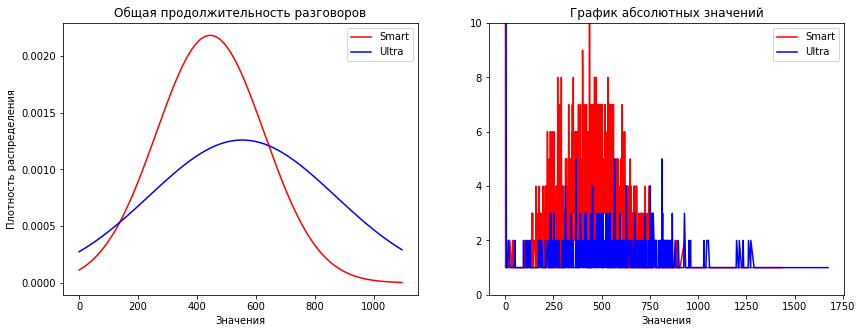

In [134]:
show_hist('sum_duration', 'Общая продолжительность разговоров', (0, 1100, 5), ylim=[0,10])

In [124]:
per_smart = len(df_smart.query('sum_duration >= minutes_included')) / len(df_smart)
per_ultra = len(df_ultra.query('sum_duration >= minutes_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", выговаривающие больше включенных минут: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", выговаривающие больше включенных минут: {per_ultra:.2%}')

Пользователи тарифа "Смарт", выговаривающие больше включенных минут: 38.33%
Пользователи тарифа "Ультра", выговаривающие больше включенных минут: 0.00%


Есть некоторая схожесть с ситуацией с интернетом:
- Дисперсия длительности звонков пользователей тарифа "Ультра" ну и как следствие график растянут. возможно также связано с тем что выборка меньше по пользователям Ультра
- Пользователи тарифа "Ультра" реже выходят за минуты включенные в тариф(В выборке вообще нет таких людей)  
- Разница среднего у пользователей не очень большая: менее 100минут в месяц

#### Смс

In [125]:
df_smart.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'reg_month', 'unreg_month', 'month',
       'gb_used', 'sum_duration', 'count_message', 'messages_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'per_minutes', 'gb_included', 'total_rub_duration',
       'total_rub_internet', 'total_rub_messages', 'total_rub_service',
       'total_rub', 'service_bool'],
      dtype='object')

STD (Ultra) | STD (Smart) : 48.88 | 28.75
VAR (Ultra) | VAR (Smart) : 2389.38 | 826.46
MEAN (Ultra)| MEAN (Smart): 51.23 | 35.57


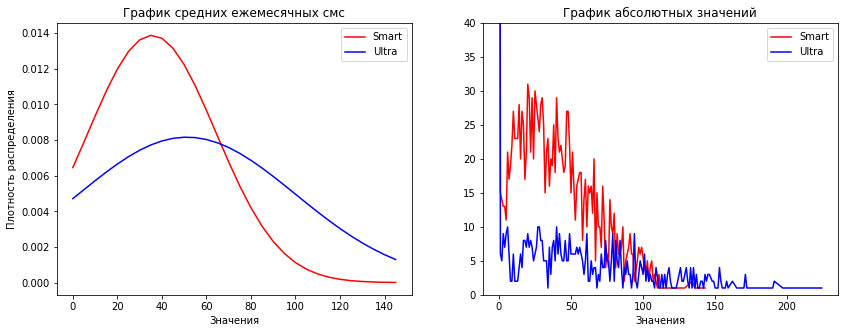

In [131]:
show_hist('count_message', 'График средних ежемесячных смс', (0, 150, 5), ylim=[0,40])

In [129]:
per_smart = len(df_smart.query('count_message >= messages_included')) / len(df_smart)
per_ultra = len(df_ultra.query('count_message >= messages_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", кто шлёт смс больше положенного: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", кто шлёт смс больше положенного: {per_ultra:.2%}')

Пользователи тарифа "Смарт", кто шлёт смс больше положенного: 28.71%
Пользователи тарифа "Ультра", кто шлёт смс больше положенного: 0.00%


In [130]:
df_main['count_message'].describe()

count   2,759.000
mean       40.432
std        36.946
min         0.000
25%        11.000
50%        33.000
75%        60.000
max       224.000
Name: count_message, dtype: float64

Удивлен, довольно много пользователей сих пор пользуются смс. в средним 1шт. в месяц. Распределения использования смс напоминает распределения использования мобильной связи и интернет трафика.  
Единственно людей которые посылают смс больше чем включено в тариф меньше, по сравнению с людьми превыщаюшими тариф интернета и телефона

In [136]:
df_main.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'reg_month', 'unreg_month', 'month',
       'gb_used', 'sum_duration', 'count_message', 'messages_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'per_minutes', 'gb_included', 'total_rub_duration',
       'total_rub_internet', 'total_rub_messages', 'total_rub_service',
       'total_rub', 'service_bool'],
      dtype='object')

In [139]:
len(df_main.query('sum_duration == 0 and count_message == 0 and gb_used == 0'))

43

#### Сравнение выручки

STD (Ultra) | STD (Smart) : 399.37 | 829.35
VAR (Ultra) | VAR (Smart) : 159492.73 | 687819.32
MEAN (Ultra)| MEAN (Smart): 2086.35 | 1388.60


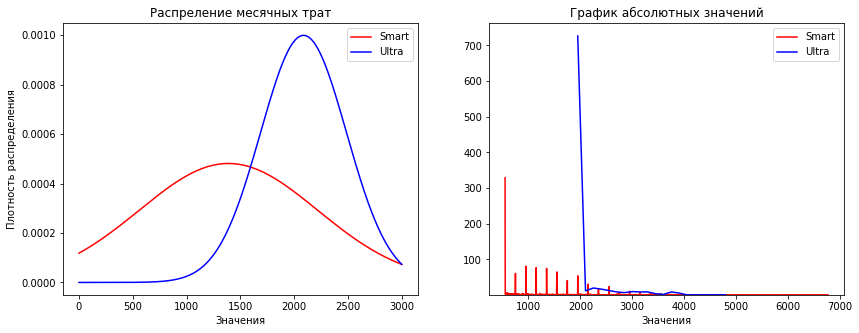

In [149]:
show_hist('total_rub','Распреление месячных трат', (0,3000))

<function matplotlib.pyplot.show(close=None, block=None)>

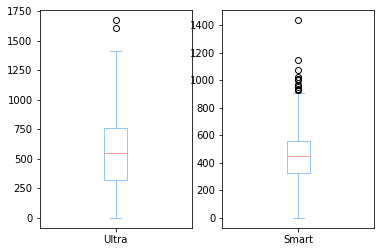

In [145]:
plt.subplot(121)
df_ultra['sum_duration'].plot(kind='box', label='Ultra')
plt.subplot(122)
df_smart['sum_duration'].plot(kind='box', label='Smart')

plt.show

Общий вывод:
- 1.5% пользователей не пользуются связью вообще.(ну точнее в опреленные месяцы)
- Выборка для пользователей тарифа "Ультра" имеет большую дисперсию и разброс данных(Это видно как и по гистограммам распределения, так и boxplot) Можно говорить о том что данных маловато
- Пользователи тарифа "Ультра" реже используют услуги сверх нормы
- Важно отметить, что основная часть докупаемых услуг - объем интернет трафика, реже: мобильная связь и смс. Компании стоит подумать о тарифе с увеличенным кол-вом трафика
- На самом деле по графика ежемесячных платежей видно, что средняя выручка c пользовтелей разная... но по ТЗ надо проверить гипотезы, поэтому переходим к сл. части задания

### Формулирование и проверка гипотез

#### Гипотеза 1. Средняя выручка

$H_0$ (Нулевая гипотеза) - Средняя выручка пользовтелей "Ультра" и "Смарт" различаются  
$H_1$ (Альтернативная двухстороняя гипотеза) - Средняя выручка пользователей одинакова

In [152]:
st.ttest_ind(df_smart['total_rub'], df_ultra['total_rub'], equal_var=True).pvalue

7.680406705337264e-111

e-111 .... тут никакой альфа не поможет. значения очень отличаются. гипотезу "Выручки различаются" не отвергаем

#### Гипотеза 2. Региональная выручка

$H_0$ (Нулевая гипотеза) - Средняя выручка пользовтелей из Москвы отличается   
$H_1$ (Альтернативная двухстороняя гипотеза) - Средняя выручка пользователей всех регионов одинаковая  
  
Тут стоит наверно отметить, что сравнивать всех пользователей не очень корректно, поэтому правильно выбрать пользователей тарифа Смарт и их сравнить и пользователей тарифа Ультра их сравнить

In [154]:
df_smart['city'].value_counts()

Москва             321
Санкт-Петербург    182
Ульяновск           71
Казань              61
Уфа                 59
                  ... 
Тула                 4
Химки                4
Нижний Тагил         4
Тверь                4
Оренбург             3
Name: city, Length: 70, dtype: int64

In [159]:
df_smart_moscow = df_smart.query('city == "Москва"')
df_smart_another_region = df_smart.query('city != "Москва"')
df_ultra_moscow = df_ultra.query('city == "Москва"')
df_ultra_another_region = df_ultra.query('city != "Москва"')

In [163]:
def ttest(df_1, df_2, alpha):
    result = st.ttest_ind(df_1['total_rub'], df_2['total_rub']).pvalue
    if  result < alpha:
        print(f'Гипотезу не отвергаем, pvalue = {result:.2}')
    else:
        print(f'Гипотезу отвергаем, pvalue = {result:.2}')

In [164]:
alpha = .05
ttest(df_smart_moscow, df_smart_another_region, alpha)
ttest(df_ultra_moscow, df_ultra_another_region, alpha)

Гипотезу отвергаем, pvalue = 0.36
Гипотезу отвергаем, pvalue = 0.93


<function matplotlib.pyplot.show(close=None, block=None)>

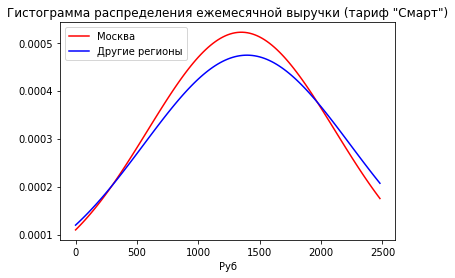

In [173]:
moscow_mean = df_smart_moscow['total_rub'].mean()
moscow_std = np.std(df_smart_moscow['total_rub'])
another_region_mean = df_smart_another_region['total_rub'].mean()
another_region_std = np.std(df_smart_another_region['total_rub'])
x_axis = np.arange(0,2500,20)
plt.plot(x_axis, st.norm.pdf(x_axis, moscow_mean, moscow_std), color='red', label='Москва')
plt.plot(x_axis, st.norm.pdf(x_axis, another_region_mean, another_region_std), color='blue', label='Другие регионы')
plt.xlabel('Руб')
plt.title('Гистограмма распределения ежемесячной выручки (тариф "Смарт")')
plt.legend()
plt.show

### Общий вывод

- Выборка пользователей тарифа "Ультра" маловата
- Большинство пользователей переплачивают за интернет (надо подумать о соответствующем тарифе)
- Пользователи тарифа "Ультра" гораздо реже выходит за пределы тарифа(вполне логично)
- Гипотезу "Пользователи тарифа "Ультра" и "Смарт" имеют разную выручку" - **Не отвергаем**:
- Гипотезу "Выручка пользователей из Москвы отличается от выручки пользователей из др.регионов" - **Отвергаем**:
- 21век... а смс актуальны... 
